# Iris Classification with Softmax Regression (From Scratch)

This notebook implements a softmax regression model from scratch (without using machine learning libraries like scikit-learn, PyTorch, or TensorFlow) to classify the Iris dataset. It covers:
- Data preprocessing and normalization
- One-hot encoding of target labels
- Softmax function and cross-entropy loss
- Manual gradient descent training
- Accuracy evaluation
- Decision boundary visualization using PCA

Importing required libraries for data handling, visualization, and PCA for dimensionality reduction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


%matplotlib inline

### Load Dataset

- Load the Iris dataset from CSV (no headers)
- Display the first few rows to inspect the data

In [2]:
data = pd.read_csv("../data/iris_data.csv", header=None)
data.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Exploratory Data Analysis

Visualize feature distributions and pairwise relationships to better understand the Iris dataset before training.

In [ ]:
# Pairplot of features colored by species
eda_data = data.copy()
eda_data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
sns.pairplot(eda_data, hue='species', diag_kind='hist')
plt.show()

### Data Preprocessing

- Extract features `X` (columns 0–3) and labels `y` (column 4)
- Normalize features using Z-score normalization
- Encode labels: setosa → 0, versicolor → 1, virginica → 2
- Split into train and validation sets (80/20)
- One-hot encode `y_train` and `y_val` for softmax classification

In [3]:
X, y = data[[0, 1, 2, 3]], data[4]

# Normalize
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Map string labels to integers
y = y.replace({
    "Iris-setosa": 0,
    "Iris-versicolor": 1,
    "Iris-virginica": 2
}).astype(int)

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode
Y_train_onehot = pd.get_dummies(y_train).reindex(columns=[0,1,2], fill_value=0).to_numpy()
Y_val_onehot = pd.get_dummies(y_val).reindex(columns=[0,1,2], fill_value=0).to_numpy()

/var/folders/rk/_r6t3b5j0jd1cjytp0py3tv00000gn/T/ipykernel_29038/122762166.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({


## Define Softmax Regression Components
We define forward pass, activation, loss, gradient calculation, and prediction functions.


In [4]:
def compute_logits(X, W, b):
    return np.dot(X, W) + b

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(Y_pred, Y_true):
    m = Y_true.shape[0]
    return -np.sum(Y_true * np.log(Y_pred + 1e-15)) / m

def compute_gradients(X, Y_true, Y_pred):
    m = X.shape[0]
    dZ = Y_pred - Y_true
    dW = np.dot(X.T, dZ) / m
    db = np.sum(dZ, axis=0, keepdims=True) / m
    return dW, db

def predict(X, W, b):
    logits = compute_logits(X, W, b)
    probs = softmax(logits)
    return np.argmax(probs, axis=1)


## Train the Model using Gradient Descent
We train the softmax model over multiple epochs, track losses, and update weights and biases.

In [5]:
# Initialize parameters
num_features = X_train.shape[1]
num_classes = 3
W = np.random.randn(num_features, num_classes) * 0.01
b = np.zeros((1, num_classes))

# Hyperparameters
learning_rate = 0.1
epochs = 1000

# Track loss
losses, val_losses = [], []

for epoch in range(epochs):
    # Forward
    logits = compute_logits(X_train, W, b)
    Y_pred = softmax(logits)
    loss = cross_entropy_loss(Y_pred, Y_train_onehot)
    
    # Validation
    val_logits = compute_logits(X_val, W, b)
    Y_val_pred = softmax(val_logits)
    val_loss = cross_entropy_loss(Y_val_pred, Y_val_onehot)
    
    # Backward
    dW, db = compute_gradients(X_train, Y_train_onehot, Y_pred)
    W -= learning_rate * dW
    b -= learning_rate * db

    losses.append(loss)
    val_losses.append(val_loss)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")


Epoch: 0, Training Loss: 1.0881, Validation Loss: 1.0853
Epoch: 100, Training Loss: 0.3411, Validation Loss: 0.2854
Epoch: 200, Training Loss: 0.2712, Validation Loss: 0.2183
Epoch: 300, Training Loss: 0.2297, Validation Loss: 0.1820
Epoch: 400, Training Loss: 0.2015, Validation Loss: 0.1583
Epoch: 500, Training Loss: 0.1810, Validation Loss: 0.1416
Epoch: 600, Training Loss: 0.1655, Validation Loss: 0.1291
Epoch: 700, Training Loss: 0.1533, Validation Loss: 0.1195
Epoch: 800, Training Loss: 0.1436, Validation Loss: 0.1119
Epoch: 900, Training Loss: 0.1355, Validation Loss: 0.1057


## Evaluate Accuracy on Training and Validation Sets
We measure how well the model performs on seen and unseen data.


In [6]:
train_acc = np.mean(predict(X_train, W, b) == y_train.to_numpy())
val_acc = np.mean(predict(X_val, W, b) == y_val.to_numpy())

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


Training Accuracy: 96.67%
Validation Accuracy: 100.00%


## Plot Training and Validation Loss Curves
These plots help us understand how well the model is learning.


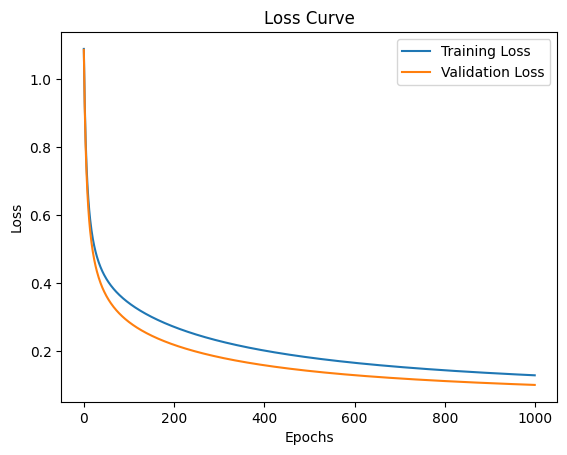

In [7]:
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()


## Visualize Decision Boundaries using PCA
We project data to 2D and draw decision boundaries using the trained model.


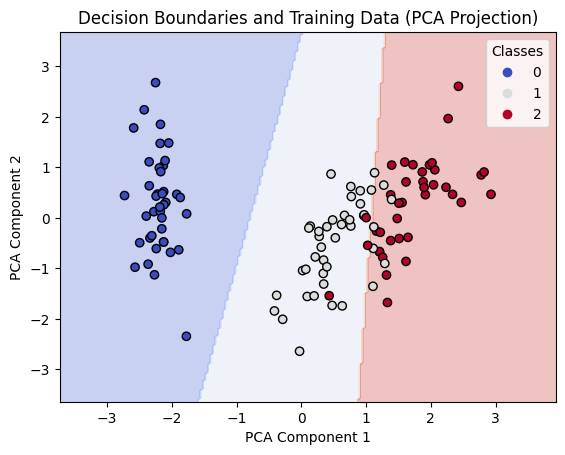

In [8]:
# Project training data to 2D
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)

# Create a meshgrid for plotting decision boundaries
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

# Inverse transform grid to original feature space
grid_original = pca.inverse_transform(grid)
Z = predict(grid_original, W, b)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolor='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundaries and Training Data (PCA Projection)')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()